# Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [9]:
%matplotlib inline

import os
import sys
import multiprocessing

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.deconvolution import deconvolve_cube
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_image
from arl.fourier_transforms.ftprocessor import *

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct LOW configuration

In [10]:
low = create_named_configuration('LOWBD2')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [11]:
times = numpy.linspace(-3.5, +3.5, 41) * numpy.pi / 12.0
frequency = numpy.linspace(0.95e8,1.05e8,5)

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

create_visibility: 26817280 rows, 32.368 GB
create_visibility: 26817280 rows, 32.368 GB


Plot the synthesized uv coverage, including for MFS

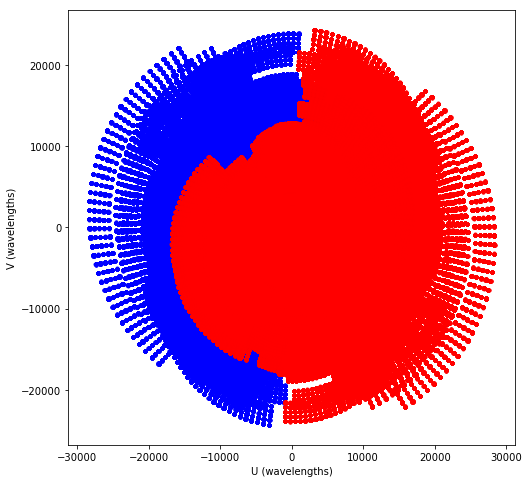

In [12]:
plt.clf()
plt.plot(vt.uvw[:,0],   vt.uvw[:,1], '.', color='b')
plt.plot(-vt.uvw[:,0], -vt.uvw[:,1], '.', color='b')
plt.xlabel("U (wavelengths)")
plt.ylabel("V (wavelengths)")
plt.show()

Now let's look at the rotation of the uvw plane

In [ ]:
time_list = []
p_list = []
q_list = []

for rows in vis_timeslice_iter(vt):
    visslice = create_visibility_from_rows(vt, rows)
    p, q = fit_uvwplane_only(visslice)
    time_list.append(numpy.average(visslice.time))
    p_list.append(p)
    q_list.append(q)
    
plt.clf()
plt.plot(time_list, p_list, color='r', label='p')
plt.plot(time_list, q_list, color='b', label='q')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('p, q value')
plt.title('Direction cosines for zenith relative to phase centre')
plt.show()

vis_timeslice_iter: Found 41 unique times
vis_timeslice_iter: Found 41 unique times
vis_timeslice_auto: Guessing time interval to be 630.00 s
vis_timeslice_auto: Guessing time interval to be 630.00 s


Make a test image

In [ ]:
vt.data['vis'] *= 0.0
npixel=4096*3

model = create_low_test_image(npixel=npixel, cellsize=0.000015)

In [ ]:
vt = predict_2d(vt, model, nprocessor='auto')

# To check that we got the prediction right, plot the amplitude of the visibility.
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

In [ ]:
vt, density, densitygrid = weight_visibility(vt, model)
plt.clf()
uvdist = numpy.sqrt(vt.u**2+vt.v**2)
plt.semilogy(uvdist[density[:,0,0]>0.0], density[:,0,0][density[:,0,0]>0], '.')
plt.title('Density of visibility subset')
plt.xlabel('UV distance (m)')
plt.ylabel('Density (weight per cell)')
plt.show()

Make the dirty image and point spread function

In [ ]:
dirty, sumwt = invert_2d(vt, model, nprocessor='auto')
dirty = normalize_sumwt(dirty, sumwt)
show_image(dirty)

psf, sumwt = invert_2d(vt, model, dopsf=True, nprocessor='auto')
psf = normalize_sumwt(psf, sumwt)


print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))
print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, 'imaging-low_dirty.fits')
export_image_to_fits(psf, 'imaging-low_psf.fits')

Deconvolve using clean

In [ ]:
comp, residual = deconvolve_cube(dirty, psf, niter=100, threshold=0.001, fracthresh=0.05, scales=[0,3,10,30])

# Show the results

fig=show_image(comp)
fig=show_image(residual)

Predict the visibility of the model

In [ ]:
vtmodel = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)
vtmodel=predict_2d(vtmodel, comp, timeslice=1.0)

Now we will plot the original visibility and the residual visibility.

In [ ]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='b', label='Original')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]-vtmodel.data['vis'][:,0,0]), '.', color='r', label='Residual')


plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()